In [1]:
# Basic python imports
import sys, os, time, h5py, logging, warnings, pickle, powerbox
import numpy as np
from scipy import interpolate, integrate

# The LambdaCDM cosmology
from astropy.cosmology import Planck18 as cosmo

# Import modified 21cmFAST
import py21cmfast as p21c
from py21cmfast import cache_tools
from py21cmfast import plotting

# Configure environment for use with DarkHistory
os.environ['DH_DIR']='/global/scratch/projects/pc_heptheory/fosterjw/21CM_Project/DarkHistory/'
sys.path.append(os.environ['DH_DIR'])
from darkhistory.spec.spectrum import Spectrum # use branch test_dm21cm

# Import DM21CM code for this project
sys.path.append("..")
import dm21cm.physics as phys
from dm21cm.utils import split_xray, get_z_edges, gen_injection_boxes, p21_step
from dm21cm.dh_wrapper import DMParams, DarkHistoryWrapper
from dm21cm.data_cacher import Cacher

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file("../matplotlibrc")
mpl.rcParams['text.usetex']=False

# Logging
logging.getLogger().setLevel(logging.INFO)
logging.getLogger('21cmFAST').setLevel(logging.CRITICAL+1)
logging.getLogger('py21cmfast._utils').setLevel(logging.CRITICAL+1)
logging.getLogger('py21cmfast.wrapper').setLevel(logging.CRITICAL+1)
logging.info(f'Using 21cmFAST version {p21c.__version__}')

/global/scratch/projects/pc_heptheory/fosterjw/21CM_Project/21cmFAST/src/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/global/scratch/projects/pc_heptheory/fosterjw/21CM_Project/21cmFAST/src/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")
INFO:root:Using 21cmFAST version 0.1.dev1579+g6b1da6d


# Configure the 21cmFAST

In [2]:
p21c.config['direc'] = '../DebugCache/'
cache_tools.clear_cache()

# The range of times and how we step
z_start = 45.
z_end = 5.
z_step_factor = 1.01

# The size and resolution of our box
HII_DIM = 64 # ['Dimensionless']
BOX_LEN = HII_DIM*2. # ['Mpccm']

In [100]:
np.geomspace(1e-26, 1e-21, 11)

array([1.00000000e-26, 3.16227766e-26, 1.00000000e-25, 3.16227766e-25,
       1.00000000e-24, 3.16227766e-24, 1.00000000e-23, 3.16227766e-23,
       1.00000000e-22, 3.16227766e-22, 1.00000000e-21])

In [3]:
p21c.global_params.Z_HEAT_MAX = z_start
p21c.global_params.ZPRIME_STEP_FACTOR = z_step_factor
p21c.global_params.CLUMPING_FACTOR = 1.

p21c_initial_conditions = p21c.initial_conditions(
    user_params = p21c.UserParams(
        HII_DIM = HII_DIM,
        BOX_LEN = BOX_LEN,
        N_THREADS = 32,
    ),
    cosmo_params = p21c.CosmoParams(
        OMm = cosmo.Om(0),
        OMb = cosmo.Ob(0),
        POWER_INDEX =cosmo.meta['n'],
        SIGMA_8 = cosmo.meta['sigma8'],
        hlittle = cosmo.h,
    ),
    random_seed = 54321,
    write = True,
)

/global/scratch/projects/pc_heptheory/fosterjw/21CM_Project/21cmFAST/src/py21cmfast/inputs.py:487: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(


# Configure the Physics with Dark History

In [4]:
struct_boost_model = 'erfc 1e-3'
run_mode = 'xray'
dhinit_list = ['phot', 'T_k', 'x_e']
dhtf_version = '230629'

dh_init_path = f"{p21c.config[f'direc']}/dhinit_soln.p"
abscs_path = f'../data/abscissas/abscs_{dhtf_version}.h5'
transfer_prefix = f'../../tf/{dhtf_version}/phot'

# Our energy injection model
dm_params = DMParams(mode = 'swave', primary = 'phot_delta', m_DM = 1e10, abscs_path = abscs_path, sigmav = 1e-23)

# Determine the boost factor model for the type of DM depletion mechanism
if dm_params.mode == 'swave':
    struct_boost = lambda rs: phys.struct_boost_func(model=struct_boost_model)(rs)
else:
    struct_boost = lambda rs: 1
    
# Generate the dark history initial conditions
logging.info('Running DarkHistory to generate initial conditions.')
from darkhistory.main import evolve as dh_evolve

dhinit_soln = dh_evolve(
                DM_process=dm_params.mode, mDM=dm_params.m_DM,
                sigmav=dm_params.sigmav, primary=dm_params.primary,
                struct_boost=phys.struct_boost_func(model=struct_boost_model),
                start_rs=3000, end_rs=z_end*0.9, coarsen_factor=12, verbose=1,
                reion_switch=False
            )
pickle.dump(dhinit_soln, open(dh_init_path, 'wb'))

INFO:root:Running DarkHistory to generate initial conditions.


****** Loading transfer functions... ******
Using data at /global/scratch/projects/pc_heptheory/fosterjw/21CM_Project/DarkHistoryData/
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******
Loading time: 11.299 s


  0%|          | 0/542 [00:00<?, ?it/s]

Initialization time: 0.023 s


 10%|▉         | 53/542 [00:03<00:26, 18.76it/s]/global/scratch/projects/pc_heptheory/fosterjw/miniconda3/envs/DM21CM/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
100%|██████████| 542/542 [00:34<00:00, 15.81it/s]

Main loop time: 34.285 s


In [5]:
# The DH Wrapper Class  
dh_wrapper = DarkHistoryWrapper(HII_DIM, dhinit_list, 1.01,
                                dh_init_path, abscs_path, transfer_prefix,
                                enable_elec = False, force_reload_tf = False)

INFO:root:Loaded photon propagation transfer function.
INFO:root:Loaded photon scattering transfer function.
INFO:root:Loaded photon deposition transfer function.


# Set Details of Caching

In [6]:
ex_lo, ex_hi = 1e2, 1e4 # [eV]
ix_lo = np.searchsorted(dh_wrapper.photeng, ex_lo) # i of first bin greater than ex_lo, excluded
ix_hi = np.searchsorted(dh_wrapper.photeng, ex_hi) # i of first bin greater than ex_hi, included

xray_fn = p21c.config['direc']+'/xray_brightness.h5'
if os.path.isfile(xray_fn):
    os.remove(xray_fn)
    
cacher = Cacher(data_path = xray_fn, cosmo = cosmo, N = HII_DIM, dx = BOX_LEN / HII_DIM)

# Evolution

In [7]:
# Where we start looking for annuli
xray_loop_start = 0

# Some details regarding our stepping
z_edges = get_z_edges(z_start, z_end, 1.01)

def get_time_step(i_z):
    current_z=z_edges[i_z]
    next_z = z_edges[i_z+1]
    
    # The cosmic time step size in [s]
    dt= ( cosmo.age(next_z) - cosmo.age(current_z) ).to('s').value
    return current_z, next_z, dt

### Synchronization

In [8]:
# Initial step with no injection
perturbed_field = p21c.perturb_field(redshift=z_edges[0], init_boxes=p21c_initial_conditions)
spin_temp, ionized_box, brightness_temp = p21_step(z_edges[0], perturbed_field, None, None)

# Manual sychronization of 21cmFAST with DarkHistory state
if 'T_k' in dhinit_list:
    T_k_DH = np.interp(1+spin_temp.redshift, dh_wrapper.dhinit_soln['rs'][::-1],
                       dh_wrapper.dhinit_soln['Tm'][::-1] / phys.kB) # [K]
    spin_temp.Tk_box += T_k_DH - np.mean(spin_temp.Tk_box)

if 'x_e' in dhinit_list:
    x_e_DH = np.interp(1+spin_temp.redshift, dh_wrapper.dhinit_soln['rs'][::-1],
                       dh_wrapper.dhinit_soln['x'][::-1, 0]) # HI
    
    spin_temp.x_e_box += x_e_DH - np.mean(spin_temp.x_e_box)
    x_H_DH = 1 - x_e_DH
    ionized_box.xH_box += x_H_DH - np.mean(ionized_box.xH_box)

if 'phot' in dhinit_list:
    logrs_dh_arr = np.log(dh_wrapper.dhinit_soln['rs'])[::-1]
    logrs = np.log(1+spin_temp.redshift)
    i = np.searchsorted(logrs_dh_arr, logrs)
    logrs_left, logrs_right = logrs_dh_arr[i-1:i+1]

    dh_spec_N_arr = np.array([s.N for s in dh_wrapper.dhinit_soln['highengphot']])[::-1]
    dh_spec_left, dh_spec_right = dh_spec_N_arr[i-1:i+1]
    dh_spec = ( dh_spec_left * np.abs(logrs - logrs_right) + \
                dh_spec_right * np.abs(logrs - logrs_left) ) / np.abs(logrs_right - logrs_left)
    phot_bath_spec = Spectrum(dh_wrapper.photeng, dh_spec, rs=1+spin_temp.redshift, spec_type='N')
else:
    phot_bath_spec = Spectrum(dh_wrapper.photeng, np.zeros_like(photeng),
                              rs=1+spin_temp.redshift, spec_type='N') # [N per Bavg]

## Now that we are synchronized, we enter our loop

In [9]:
records = []

for i_z in range(len(z_edges)-1):
    start = time.time()

    # Print some information about the step we are taking
    current_z, next_z, dt = get_time_step(i_z)

    print('Starting step: ', i_z)
    print('Currently at: ', current_z)
    print('Advancing to: ', next_z)
    
    # Derived quantities that I need
    nBavg = phys.n_B * (1+current_z)**3 # [Bavg / (physical cm)^3]

    delta_plus_one_box = 1+ np.asarray(perturbed_field.density)
    rho_DM_box = delta_plus_one_box * phys.rho_DM * (1+current_z)**3 # [eV/(physical cm)^3]
    x_e_box = np.asarray(1 - ionized_box.xH_box) # check this
    inj_per_Bavg_box = phys.inj_rate(rho_DM_box, dm_params) * dt * struct_boost(1+current_z) / nBavg # [inj/Bavg]
    
    # Kwargs for the transfer function interpolation. I had to put the hacky cap on `x_s`. Look into this
    tf_kwargs = dict(rs = 1 + current_z,
                     nBs_s = delta_plus_one_box.ravel(),
                     x_s = np.minimum(.999, x_e_box).ravel(), 
                     out_of_bounds_action = 'clip'
                    )
    
    # Construct the empty arrays we deposit into and set the kwargs
    dh_wrapper.set_empty_arrays(tf_kwargs)  
    
    #############################
    ###   Energy Deposition   ###
    #############################
        
    # Now calculate photon emission and energy deposition from our X-ray annuli
    for i_z_shell in range(xray_loop_start, i_z):
        
        # Load the cached data
        effective_density, xray_spec, is_box_average = cacher.get_annulus_data(current_z,
                                                                               z_edges[i_z_shell],
                                                                               z_edges[i_z_shell+1])

        # If we are smoothing on the scale of the box then dump to the global bath spectrum.
        # The deposition will happen later, and we will not revisit this shell.
        if is_box_average:
            phot_bath_spec.N += effective_density[0, 0, 0]*xray_spec.N
            xray_loop_start = max(i_z_shell+1, xray_loop_start)
            continue

        dh_wrapper.photon_injection(xray_spec, injection_type = 'xray', weight_box = effective_density)

    # Homogeneous bath injection
    dh_wrapper.photon_injection(phot_bath_spec, injection_type = 'bath', weight_box = None)
    
    # On the spot injection from DM
    dh_wrapper.photon_injection(dm_params.inj_phot_spec, injection_type='ots', weight_box=inj_per_Bavg_box)
    
    #############################################################
    ###   Generate the input boxes and take a 21cmFAST step   ###
    #############################################################
    
    # Access the propagating photon spectrum, emitted photon spectrum, and deposition box
    prop_phot_N, emit_phot_N, dep_box = dh_wrapper.get_state_arrays()
    
    perturbed_field = p21c.perturb_field(redshift=next_z, init_boxes=p21c_initial_conditions)    
    input_heating, input_ionization, input_jalpha = gen_injection_boxes(next_z, p21c_initial_conditions)
    dh_wrapper.populate_injection_boxes(input_heating, input_ionization, input_jalpha,
                                        x_e_box, delta_plus_one_box, nBavg)
     
    spin_temp, ionized_box, brightness_temp = p21_step(next_z, perturbed_field, spin_temp, ionized_box,
                                                       input_heating, input_ionization, input_jalpha)
    
    ########################################################
    ###   Prepare X-Ray and Bath Spectra for Next Step   ###
    ########################################################
    
    # Advance all cached spectra through this redshift step.        
    dep_tf_at_point = dh_wrapper.phot_dep_tf.point_interp(rs=1+current_z, nBs=1, x=np.mean(x_e_box))
    dep_toteng = np.sum(dep_tf_at_point[:, :4], axis=1)
    attenuation_factor = 1 - dep_toteng/dh_wrapper.photeng
    
    cacher.advance_spectrum(attenuation_factor, next_z)
    
    ################################################################
    ###   Cache X-Ray Emission from this Step and Prepare Bath   ###
    ################################################################
        
    # Split the x-ray spectrum into bath and emission
    emit_bath_N, emit_xray_N = split_xray(emit_phot_N, ix_lo, ix_hi)
    out_phot_N = prop_phot_N + emit_bath_N
    
    # Prepare the bath spectrum for the next step    
    out_phot_spec = Spectrum(dh_wrapper.photeng, out_phot_N, rs=1+current_z, spec_type='N')
    out_phot_spec.redshift(1+next_z)
    phot_bath_spec = out_phot_spec
    
    # Redshift the x-ray spectrum to the next timestep. Then cache the brightness box and spectrum
    xray_spec = Spectrum(dh_wrapper.photeng, emit_xray_N, rs=1+current_z, spec_type='N') # [photon / Bavg]
    xray_spec.redshift(1+next_z)
    
    xray_e_box = dep_box[..., 5] / np.dot(dh_wrapper.photeng, emit_xray_N) # energy / B_avg
    cacher.set_cache(current_z, xray_e_box, xray_spec)
    
    #######################################################
    ###   Save some Global Quantities for Convenience   ###
    #######################################################
    
    dE_inj_per_Bavg = dm_params.eng_per_inj * np.mean(inj_per_Bavg_box) # [eV per Bavg]
    dE_inj_per_Bavg_unclustered = dE_inj_per_Bavg / struct_boost(1+current_z)

    record_inj = {'dE_inj_per_B' : dE_inj_per_Bavg,
                  'f_ion'  : np.mean(dep_box[...,0] + dep_box[...,1]) / dE_inj_per_Bavg_unclustered,
                  'f_exc'  : np.mean(dep_box[...,2]) / dE_inj_per_Bavg_unclustered,
                  'f_heat' : np.mean(dep_box[...,3]) / dE_inj_per_Bavg_unclustered,
    }
    
    record = {
        'z'   : next_z,
        'T_s' : np.mean(spin_temp.Ts_box), # [mK]
        'T_b' : np.mean(brightness_temp.brightness_temp), # [K]
        'T_k' : np.mean(spin_temp.Tk_box), # [K]
        'x_e' : np.mean(1 - ionized_box.xH_box), # [1]
        'E_phot' : phot_bath_spec.toteng(), # [eV/Bavg]
    }
    if run_mode in ['bath', 'xray']:
        record.update(record_inj)
    records.append(record)
    print(record['T_b'])
    
    arr_records = {k: np.array([r[k] for r in records]) for k in records[0].keys()}
    np.save('./New_Debug', arr_records)
    
    end = time.time()
    print('Time Elapsed:', end-start)
    print()

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


Starting step:  0
Currently at:  45.0
Advancing to:  44.67846508307498
-17.926395
Time Elapsed: 8.707759380340576

Starting step:  1
Currently at:  44.67846508307498
Advancing to:  44.22620305254949


/global/scratch/projects/pc_heptheory/fosterjw/21CM_Project/DM21cm/notebooks/../dm21cm/data_cacher.py:71: RuntimeWarning: invalid value encountered in divide
  W1 = 3*(np.sin(self.kMag*R1) - self.kMag*R1 * np.cos(self.kMag*R1)) /(self.kMag*R1)**3
/global/scratch/projects/pc_heptheory/fosterjw/21CM_Project/DM21cm/notebooks/../dm21cm/data_cacher.py:72: RuntimeWarning: invalid value encountered in divide
  W2 = 3*(np.sin(self.kMag*R2) - self.kMag*R2 * np.cos(self.kMag*R2)) /(self.kMag*R2)**3


-17.191023
Time Elapsed: 6.634235858917236

Starting step:  2
Currently at:  44.22620305254949
Advancing to:  43.77841886391038
-16.172785
Time Elapsed: 7.350754976272583

Starting step:  3
Currently at:  43.77841886391038
Advancing to:  43.335068182089486
-15.183008
Time Elapsed: 8.510751485824585

Starting step:  4
Currently at:  43.335068182089486
Advancing to:  42.89610711097969
-14.243696
Time Elapsed: 9.84022331237793

Starting step:  5
Currently at:  42.89610711097969
Advancing to:  42.4614921890888
-13.353523
Time Elapsed: 10.569618225097656

Starting step:  6
Currently at:  42.4614921890888
Advancing to:  42.03118038523644
-12.510411
Time Elapsed: 12.274002075195312

Starting step:  7
Currently at:  42.03118038523644
Advancing to:  41.6051290942935
-11.712163
Time Elapsed: 11.823071241378784

Starting step:  8
Currently at:  41.6051290942935
Advancing to:  41.18329613296386
-10.9566765
Time Elapsed: 12.289660930633545

Starting step:  9
Currently at:  41.18329613296386
Advanci

0.63241863
Time Elapsed: 10.704792022705078

Starting step:  65
Currently at:  23.162595300401538
Advancing to:  22.92336168356588
0.66195726
Time Elapsed: 10.678223133087158

Starting step:  66
Currently at:  22.92336168356588
Advancing to:  22.686496716401862
0.69484997
Time Elapsed: 11.390250444412231

Starting step:  67
Currently at:  22.686496716401862
Advancing to:  22.451976946932536
0.73204815
Time Elapsed: 9.656676054000854

Starting step:  68
Currently at:  22.451976946932536
Advancing to:  22.21977915537875
0.77467227
Time Elapsed: 9.701647758483887

Starting step:  69
Currently at:  22.21977915537875
Advancing to:  21.989880351860148
0.8241948
Time Elapsed: 9.911722898483276

Starting step:  70
Currently at:  21.989880351860148
Advancing to:  21.762257774118957
0.88189316
Time Elapsed: 10.194956064224243

Starting step:  71
Currently at:  21.762257774118957
Advancing to:  21.536888885266293
0.94886684
Time Elapsed: 10.229078531265259

Starting step:  72
Currently at:  21.53

17.574884
Time Elapsed: 8.685335397720337

Starting step:  129
Currently at:  11.781318518237835
Advancing to:  11.65477081013647
17.793335
Time Elapsed: 8.882383584976196

Starting step:  130
Currently at:  11.65477081013647
Advancing to:  11.52947604964007
17.994816
Time Elapsed: 8.527952909469604

Starting step:  131
Currently at:  11.52947604964007
Advancing to:  11.405421831326802
18.1815
Time Elapsed: 8.57679033279419

Starting step:  132
Currently at:  11.405421831326802
Advancing to:  11.282595872600794
18.354568
Time Elapsed: 9.288140535354614

Starting step:  133
Currently at:  11.282595872600794
Advancing to:  11.160986012476034
18.509302
Time Elapsed: 9.244421005249023

Starting step:  134
Currently at:  11.160986012476034
Advancing to:  11.04058021037231
18.641478
Time Elapsed: 9.227949142456055

Starting step:  135
Currently at:  11.04058021037231
Advancing to:  10.92136654492308
18.754255
Time Elapsed: 9.188561916351318

Starting step:  136
Currently at:  10.921366544923

0.33012557
Time Elapsed: 8.92176103591919

Starting step:  193
Currently at:  5.76095018079182
Advancing to:  5.694010079991901
0.25741458
Time Elapsed: 9.307666540145874

Starting step:  194
Currently at:  5.694010079991901
Advancing to:  5.627732752467228
0.19701773
Time Elapsed: 9.261777400970459

Starting step:  195
Currently at:  5.627732752467228
Advancing to:  5.562111636106167
0.14985113
Time Elapsed: 9.549764156341553

Starting step:  196
Currently at:  5.562111636106167
Advancing to:  5.497140233768482
0.11349516
Time Elapsed: 9.430321455001831

Starting step:  197
Currently at:  5.497140233768482
Advancing to:  5.432812112642061
0.08559762
Time Elapsed: 8.957208633422852

Starting step:  198
Currently at:  5.432812112642061
Advancing to:  5.369120903606001
0.06317915
Time Elapsed: 8.96072244644165

Starting step:  199
Currently at:  5.369120903606001
Advancing to:  5.306060300600001
0.044265993
Time Elapsed: 9.00771427154541

Starting step:  200
Currently at:  5.306060300600

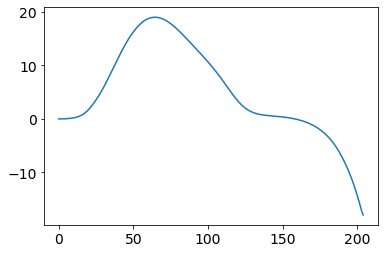

In [110]:
plt.plot(arr_records['T_b'][::-1])

# Below we make Lightcones and Power Spectra

In [10]:
lightcone_quantities = ('brightness_temp','Ts_box','xH_box',"dNrec_box",'z_re_box',
                        'Gamma12_box','J_21_LW_box',"density")


In [11]:
lightcone= p21c.run_lightcone(
        redshift = z_edges[-1],
        init_box = p21c_initial_conditions,
        flag_options = ionized_box.flag_options,
        astro_params = ionized_box.astro_params,
        lightcone_quantities=lightcone_quantities,
        global_quantities=lightcone_quantities,
        random_seed = 54321,
        direc = '../DebugCache/',
)


/global/scratch/projects/pc_heptheory/fosterjw/21CM_Project/21cmFAST/src/py21cmfast/_utils.py:821: UserWarning: Trying to remove array that isn't yet created: hires_vx
  warnings.warn(f"Trying to remove array that isn't yet created: {k}")
/global/scratch/projects/pc_heptheory/fosterjw/21CM_Project/21cmFAST/src/py21cmfast/_utils.py:821: UserWarning: Trying to remove array that isn't yet created: hires_vy
  warnings.warn(f"Trying to remove array that isn't yet created: {k}")
/global/scratch/projects/pc_heptheory/fosterjw/21CM_Project/21cmFAST/src/py21cmfast/_utils.py:821: UserWarning: Trying to remove array that isn't yet created: hires_vz
  warnings.warn(f"Trying to remove array that isn't yet created: {k}")
/global/scratch/projects/pc_heptheory/fosterjw/21CM_Project/21cmFAST/src/py21cmfast/_utils.py:821: UserWarning: Trying to remove array that isn't yet created: hires_vx_2LPT
  warnings.warn(f"Trying to remove array that isn't yet created: {k}")
/global/scratch/projects/pc_heptheory/f

array([ 5.00000001,  5.00372525,  5.00745392, ..., 44.98975847,
       45.06889177, 45.14823072])

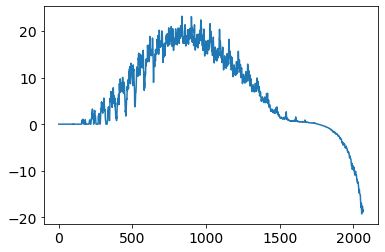

In [106]:
plt.plot(np.mean(lightcone.brightness_temp[0], axis = 0))

In [39]:
lightcone_redshifts = lightcone.lightcone_redshifts

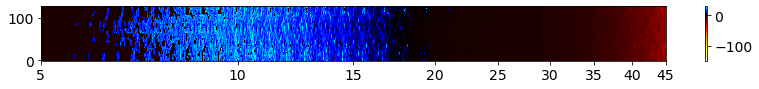

In [76]:
fig, ax = plt.subplots(figsize = (14, 1))

im = ax.pcolormesh(lightcone_redshifts, np.arange(cacher.N)*cacher.dx, 
              lightcone.brightness_temp[0], cmap = mpl.colormaps['EoR'], vmin = -150, vmax = 30)

ax.set_xscale('log')
ax.set_xticks([], minor = True)
ax.set_xlim(5, 45)

ax.set_xticks([5, 10, 15, 20, 25, 30, 35, 40, 45], minor = False)
ax.set_xticklabels(['5', '10', '15', '20', '25', '30', '35', '40', '45'], minor = False)

cax = plt.colorbar(im)
plt.show()


In [77]:
def compute_power(
   box,
   length,
   n_psbins,
   log_bins=True,
   ignore_kperp_zero=True,
   ignore_kpar_zero=False,
   ignore_k_zero=False,
):
    # Determine the weighting function required from ignoring k's.
    k_weights = np.ones(box.shape, int)
    n0 = k_weights.shape[0]
    n1 = k_weights.shape[-1]

    if ignore_kperp_zero:
        k_weights[n0 // 2, n0 // 2, :] = 0
    if ignore_kpar_zero:
        k_weights[:, :, n1 // 2] = 0
    if ignore_k_zero:
        k_weights[n0 // 2, n0 // 2, n1 // 2] = 0

    res = powerbox.tools.get_power(
        box,
        boxlength=length,
        bins=n_psbins,
        bin_ave=False,
        get_variance=False,
        log_bins=log_bins,
        k_weights=k_weights,
    )

    res = list(res)
    k = res[1]
    if log_bins:
        k = np.exp((np.log(k[1:]) + np.log(k[:-1])) / 2)
    else:
        k = (k[1:] + k[:-1]) / 2

    res[1] = k
    return res

def powerspectra(brightness_temp, n_psbins=50, nchunks=20, min_k=0.1, max_k=1.0, logk=True):
    data = []
    chunk_indices = list(range(0,brightness_temp.n_slices, int(np.floor(brightness_temp.n_slices / nchunks),)) )   
    print(chunk_indices)
    if len(chunk_indices) > nchunks:
        chunk_indices = chunk_indices[:-1]
    chunk_indices.append(brightness_temp.n_slices)

    for i in range(nchunks):
        start = chunk_indices[i]
        end = chunk_indices[i + 1]
        chunklen = (end - start) * brightness_temp.cell_size

        power, k = compute_power(
            brightness_temp.brightness_temp[:, :, start:end],
            (BOX_LEN, BOX_LEN, chunklen),
            n_psbins,
            log_bins=logk,
        )
        data.append({"k": k, "delta": power * k ** 3 / (2 * np.pi ** 2)})
    return data

In [78]:
k_fundamental = 2*np.pi/BOX_LEN
k_max = k_fundamental * HII_DIM
Nk=np.floor(HII_DIM/1).astype(int)

out = powerspectra(lightcone, min_k = k_fundamental, max_k = k_max)

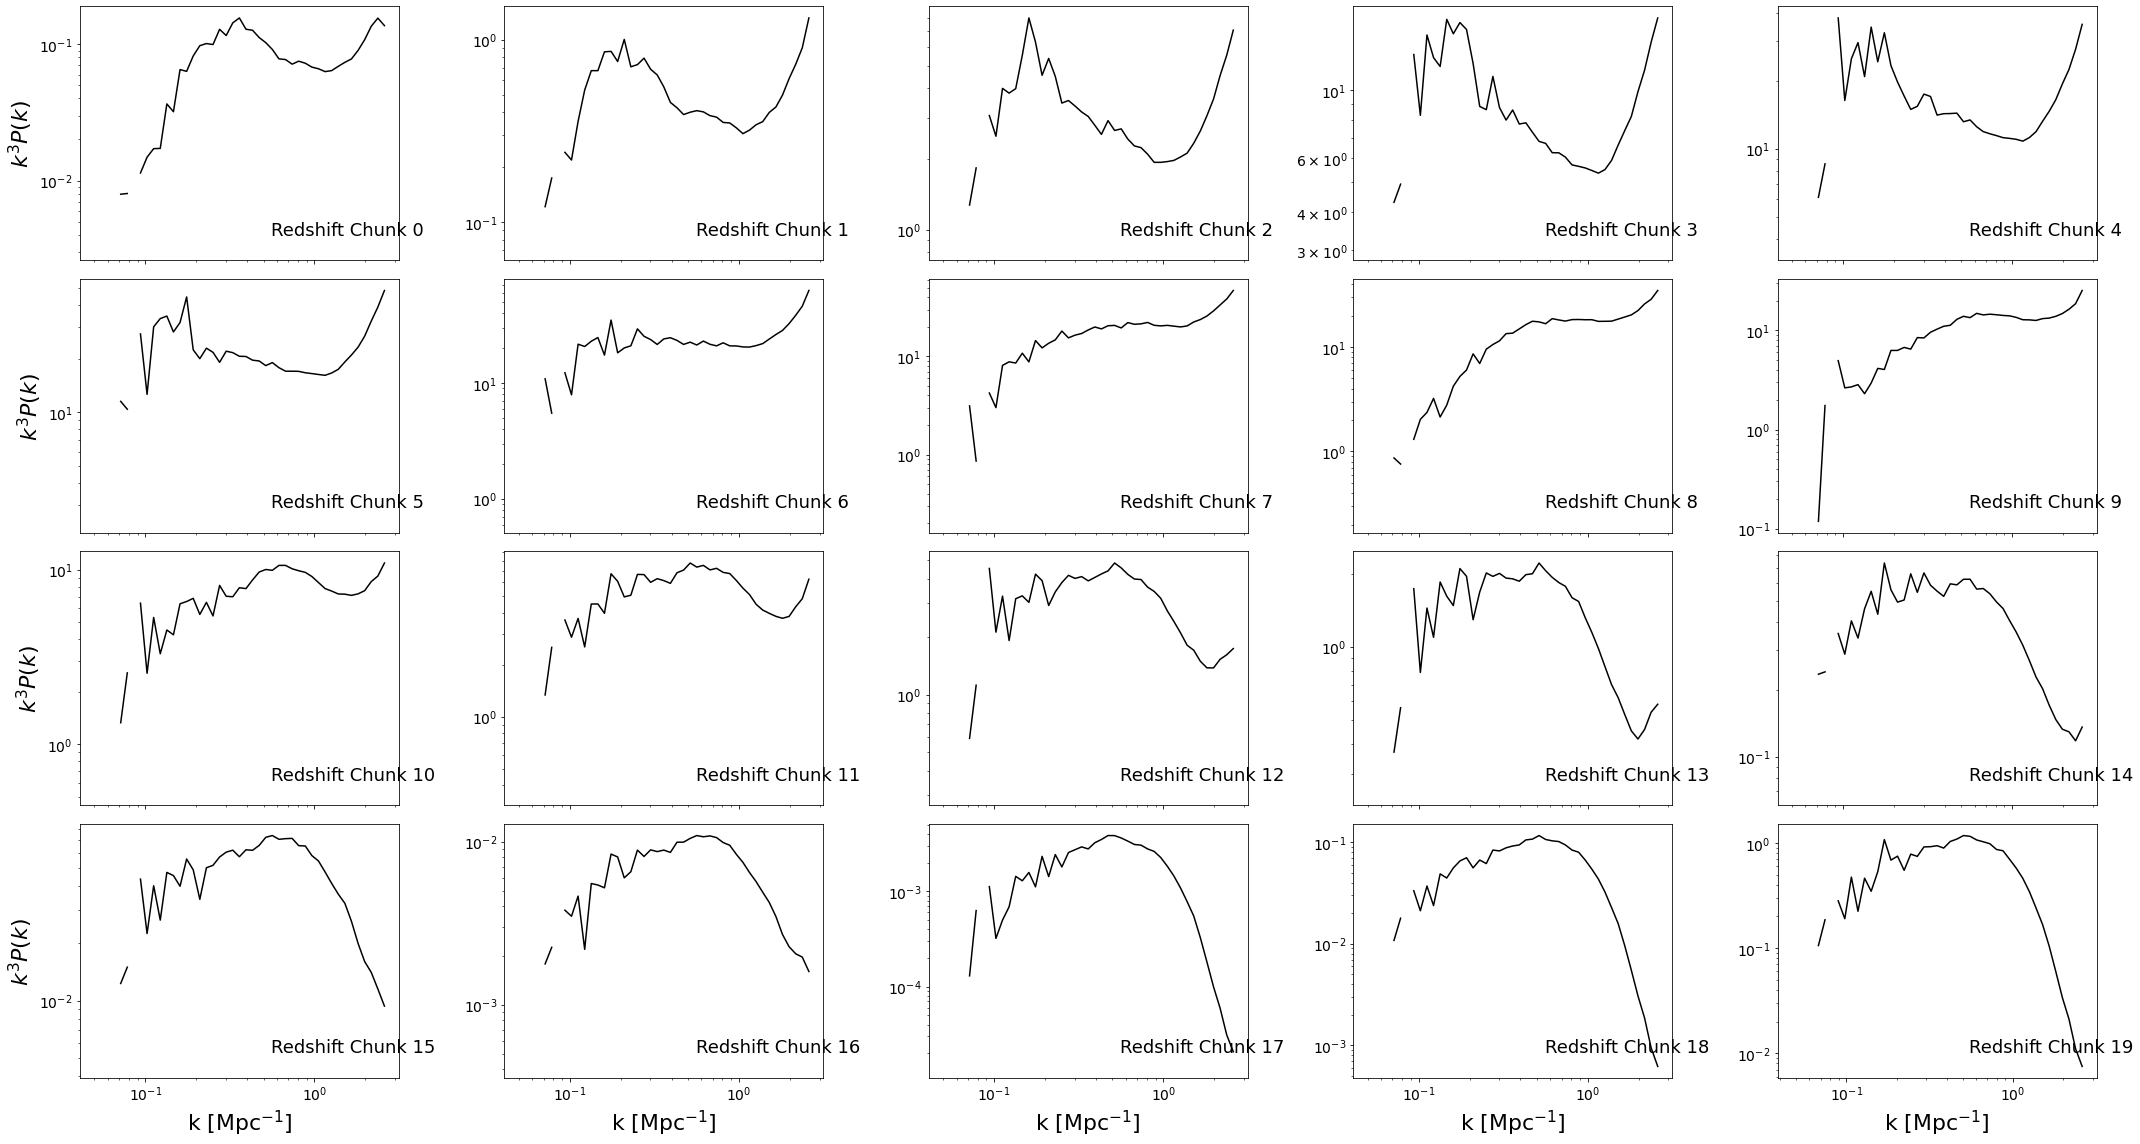

In [99]:
fig, axs = plt.subplots(ncols = 5, nrows = 4, figsize = (30, 16))

for i, item in enumerate(out):
    row_index, col_index = np.unravel_index(i, axs.shape)
    
    ax = axs[row_index, col_index]
    ax.plot(item['k'], item['delta'], color = 'black')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.text(.6, .1, 'Redshift Chunk ' + str(i), transform=ax.transAxes, fontsize = 18)
    
for i in range(axs.shape[0]-1):
    for j in range(axs.shape[1]):
        axs[i, j].set_xticklabels([])

for j in range(axs.shape[1]):
    axs[-1, j].set_xlabel('k [Mpc$^{-1}$]', fontsize = 22)
for i in range(axs.shape[0]):
    axs[i, 0].set_ylabel('$k^3 P(k)$', fontsize = 22)
    
plt.tight_layout()
plt.show()